# Step 1:  Implement the Histogram of Curvature Scale

Write a function called HoCS that returns a histogram of curvature scale feature vector for a given region.  The inputs to your function should be:

- `B`: a binary image that contains exactly one foreground connected component.
- `min_scale`: The smallest scale (circle radius) at which to calcluate curvature
- `max_scale`: The largest scale (circle radius) at which to calculate curvature
- `increment`: The increment at which intermediate curvatures should be calculated (must be a positive integer)
- `num_bins`: The number of bins in the histogram of curvature for a single scale (must be a positive integer)

Your function should compute a histogram of curvature for each scale, starting at `min_scale` ending at (at most) `max_scale`, and for intermediate scales at increments of `increment`.  For example, if `min_scale`=4 and `max_scale`=20, and `increment`=3, then the function should compute a histogram of curvature for scales 4, 7, 10, 13, 16, and 19.  Each histogram at each scale should have `num_bins` bins.  Curvature must be computed using the normalized area integral invariant method described on Slide 39 of the Topic 9 lecture notes.  

Normalize each histogram at each scale.

To keep things straightforward, your functions should only consider the outer perimeter of the input region; ignore the boundaries of holes in the region.

After computing the histogram of curvature at each of the specified scales, all of the histograms should be concatenated into a single one-dimensional array (feature vector) and then returned.

_Implementation hint:  You can calculate the normalized area integral invariant of each pixel efficiently using linear filtering.  You will find the function `skimage.morphology.disk()` function useful for designing the appropriate filter masks._

_Implementation hint:  Most of the heavy lifting here can be done with module functions from `skimage`, `numpy`, and `scipy`.  Many of the functions mentioned in class and in the notes will be useful.  One that we might not have covered, but will be very handy is `numpy.histogram()`.  When you use it, makes sure you specify both the `bins` and `range` optional arguments. Also note that `numpy.histogram()` returns TWO things.  You only need the first one, so make sure you write your function call like this:_

`the_histogram, stuff_you_dont_need = np.histogram(...)`


In [1]:
import numpy as np
import scipy.ndimage as nd
import skimage.segmentation as seg
import skimage.morphology as morph

def HoCS(B: np.ndarray, min_scale: int, max_scale: int, increment: int, num_bins: int) -> np.ndarray:
    '''
    Computes a histogram of curvature scale for the shape in the binary image B.  
    Boundary fragments due to holes are ignored.
    :param B: A binary image consisting of a single foreground connected component.
    :param min_scale: smallest scale to consider (minimum 1)
    :param max_scale: largest scale to consider (max_scale > min_scale)
    :param increment:  increment on which to compute scales between min_scale and max_scale
    :param num_bins: number of bins for the histogram at each scale
    :return: 1D array of histograms concatenated together in order of increasing scale.
    
    Note: a curvature values are between 0.0 and 1.0 are interpreted thusly:
       0.0 - values close to 0 arise from highly convex points.
       0.5 - no curvature
       1.0 - values close to 1 arise from highly concave points.
    '''

    if max_scale < min_scale:
        raise ValueError('max_scale must be larger than min_scale')
    if num_bins < 1:
        raise ValueError('num_bins must be >= 1')
    
    b_holes_filled = nd.binary_fill_holes(B)
    boundary_points = seg.find_boundaries(b_holes_filled, connectivity=1, mode='inner') 
    boundary_points = np.where(boundary_points > 0)
    boundary_points = np.transpose(np.vstack(boundary_points))
    
    histograms = list()
    for radius in np.arange(min_scale, max_scale + 1, increment):

        disk = morph.disk(radius) 
        disk = disk / np.sum(disk)
        
        convolved = nd.filters.convolve(util.img_as_float(b_holes_filled), disk)
        curvatures = convolved[boundary_points[ : , 0], boundary_points[ : , 1]]
        
        h, bin_edges = np.histogram(curvatures, bins=num_bins, range=(0.0, 1.0))
        histograms.append(h / len(curvatures))
        
    return np.hstack(histograms)

# Step 2: Test your HoCS function.

Run HoCS on `threshimage_0001.png` from the ground truth for assignment 3.  Use `min_scale=5`, `max_scale=25`, `increment=10`, `num_bins=10`.  Plot the resulting feature vector as a bar graph.  Set the y-axis limits to be between 0.0 and 1.0.  You should get a result that matches the sample output in the assignment description.


<BarContainer object of 30 artists>

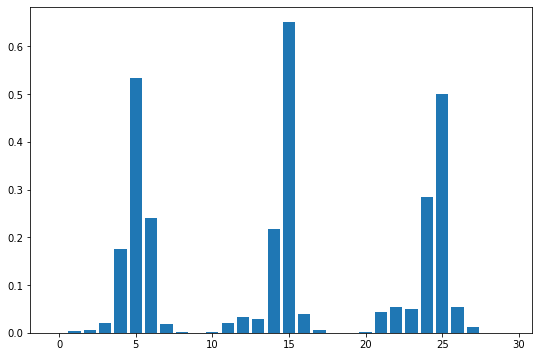

In [2]:
import skimage.io as io
import skimage.util as util
import matplotlib.pyplot as plt 

%matplotlib inline

img = util.img_as_float(io.imread('./leaftraining/threshimage_0001.png'))
img_hist = HoCS(img, 5, 25, 10, 10)
plt.figure(figsize=(9, 6))
plt.bar(np.arange(len(img_hist)), img_hist)

# Step 3: Calculate training features.

Use your function from Step 1 to compute the HoCS feature for each of the training images.  Use them to train a k-nearest neigbour classifier.  It is up to you to determine the parameters for the HoCS feature such as `min_scale`, `max_scale`, etc. to maximize the classification rate.  This will require some experimentation.  Slides 19-21 of Topic 12 lecture notes will be helpful here.

Also generate the training labels here (a column-array of numbers indicating which descriptors belong to each class, e.g. use values 1,2,3 to indicate class 1, 2, and 3.).

In [3]:
import os as os
from tqdm import tqdm

def get_features(path: str) -> tuple:
    features = list()
    for root, dirs, files in os.walk(path):
        for f in tqdm(sorted(files)):
            if f[-4 : ] == '.png':
                #print('Calculating features for', f)
                B = io.imread(os.path.join(root, f))
                f = HoCS(B, min_scale=5, max_scale=30, increment=5, num_bins=15)
                features.append(f)
    return np.vstack(features), sorted(files) 

train_labels = np.zeros(30, dtype='int')
train_labels[10:20] = 1
train_labels[20:] = 2

train_data, train_files = get_features(os.path.join('.', 'leaftraining')) 

100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


## Step 3.1: Visualize the training features via dimension reduction 

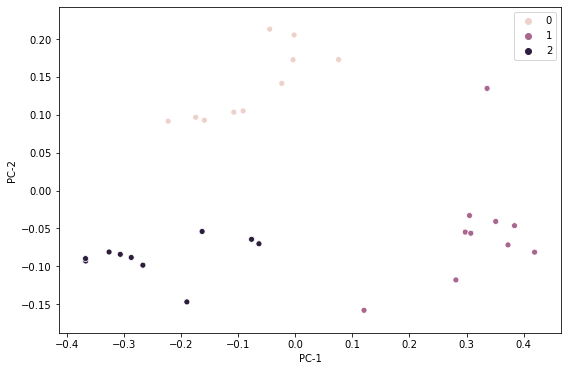

In [4]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

reductor_pca = PCA(n_components = 3)
train_data_pca = reductor_pca.fit_transform(train_data)
reductor_pca.explained_variance_ratio_

train_data_pca = pd.DataFrame(data=train_data_pca, columns=['PC-1', 'PC-2', 'PC-3'])
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=train_data_pca, 
    x='PC-1', y='PC-2',
    hue=train_labels
)

# Step 4: Calculate the testing features.

Compute the HoCS features for all of the testing images.  Use the same HoCS parameters you did in Step 3.  Also generate class labels for the testing image descriptors.

In [5]:
test_labels = np.zeros(129, dtype = 'int')
test_labels[50:77] = 1
test_labels[77:] = 2

test_data, test_files = get_features(os.path.join('.', 'leaftesting')) 

100%|██████████| 129/129 [08:39<00:00,  4.03s/it]


# Step 5: Train the classifier using the feature vectors from the training images.

You have another opportunity here to optimize parameters.  You can experiment with different classifiers (in partiuclar KNN) to try to obtain better classification rates.  But you won't really be able to do this until after step 6, so just use default parameters to start with.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans

classifiers = [
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    #GaussianNB(),
    #DecisionTreeClassifier(),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #QuadraticDiscriminantAnalysis(),
    KMeans(n_clusters=3, init=np.take(train_data, [1, 11, 21], axis = 0))]

# Step 6: Classfiy the testing features.

Classify the testing image features.

Determine the classification rate and the confusion matrix by comparing the results of the classifier to the true class labels for each image.  

Print out the filenames of incorrectly classified images.

Print the confusion matrix (you don't have to print the row/column indicies as in the example in the assignment description), just the rows and columns of the matrix itself.

Print the correct classification rate.

It should be very easy to get a classficiation rate more than 90%; with care you should be able to get as much as 95%.

In [7]:
for clf in classifiers:
    print("Using classifier", clf)
    clf.fit(train_data, train_labels)
    predict_labels = clf.predict(test_data)
    correct_labels = (predict_labels == test_labels)
    
    # Compute and print out the classification rate.
    correct_rate = np.sum(correct_labels) / len(predict_labels)
    print('The classification rate was', correct_rate * 100, 'percent.')

    # obtain the filenames of images that were incorrectly classified.
    incorrectly_classified = \
        [test_files[i] for i in range(len(test_files)) if not correct_labels[i]]

    # Print out the names of incorrectly classified images.
    for f in incorrectly_classified:
        print(f, 'was incorrectly classified.')
    print()  
    
    # Compute and print out the confusion matrix.
    confusion = np.zeros((3, 3), dtype = 'int')
    
    for i in range(len(predict_labels)):
        confusion[test_labels[i] - 1, predict_labels[i] - 1] += 1
        
    print('The confusion matrix is:')
    for x in confusion:
        print('{:5}, {:5}, {:5}'.format(x[0], x[1], x[2]))
    print()

Using classifier KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
The classification rate was 91.47286821705426 percent.
image_0023.png was incorrectly classified.
image_0046.png was incorrectly classified.
image_0130.png was incorrectly classified.
image_0134.png was incorrectly classified.
image_0140.png was incorrectly classified.
image_0144.png was incorrectly classified.
image_0145.png was incorrectly classified.
image_0153.png was incorrectly classified.
image_0173.png was incorrectly classified.
image_0185.png was incorrectly classified.
image_0186.png was incorrectly classified.

The confusion matrix is:
   27,     0,     0
    1,    43,     8
    2,     0,    48

Using classifier SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, p

/home/xil/miniconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)
